In [2]:
import json

with open('/home/steohan/ma/thesis/benchresults/incphp/sat-paper-run1.json', 'r') as jsonFile:
    config = json.loads(jsonFile.read())

In [3]:
confIds = dict()
for experiment in config["runResults"]:
    conf = json.dumps(experiment["conf"]["setup"], indent=4)
    confId = hash(conf)
    confIds[confId] = conf

In [4]:
import math


def computeName(x):
    name = ''
    if (x['conf.setup.incremental']):
        name += 'incr. '    
    if x['conf.setup.variant.3sat']:
        name += '3SAT '
    if x['conf.setup.variant.addAssumed']:
        name += 'addAssumed '
    if x['conf.setup.variant.alternate']:
        name += 'alternate '
    if x['conf.setup.variant.extendedResolution']:
        name += 'extended '
    if x['conf.setup.record']:
        name += 'recording '
    if name == '':
        name = 'normal'
    return name

In [5]:
from pandas.io.json import json_normalize
import pandas

df = json_normalize(config["runResults"])
toFillNan = [
    "incphp.result.executionTime.userTime",
    "incphp.result.executionTime.systemTime",
    "incphp.result.executionTime.returnCode"
]

df[toFillNan] = df[toFillNan].fillna(value=0.0)
df = df.assign(
    time = lambda x: 
        x["incphp.result.executionTime.userTime"]
        + x["incphp.result.executionTime.systemTime"],
    error = lambda x: 
        (x["incphp.result.executionTime.returnCode"] != 0),
    confId = [hash(json.dumps(experiment["conf"]["setup"], indent=4)) for experiment in config["runResults"]]
)
df = df.assign(name = lambda x: x.apply(computeName, axis = 1))

In [5]:
list(df)

['%limits.RLIMIT_AS',
 '%limits.RLIMIT_CPU',
 'conf.numPigeons',
 'conf.run',
 'conf.setup.incremental',
 'conf.setup.record',
 'conf.setup.solver',
 'conf.setup.variant.3sat',
 'conf.setup.variant.addAssumed',
 'conf.setup.variant.alternate',
 'conf.setup.variant.extendedResolution',
 'incphp.parameters.3sat',
 'incphp.parameters.addAssumed',
 'incphp.parameters.alternate',
 'incphp.parameters.binDir',
 'incphp.parameters.dimspec',
 'incphp.parameters.extendedResolution',
 'incphp.parameters.incremental',
 'incphp.parameters.numPigeons',
 'incphp.parameters.print',
 'incphp.parameters.record',
 'incphp.parameters.solver',
 'incphp.result.executionTime.returnCode',
 'incphp.result.executionTime.systemTime',
 'incphp.result.executionTime.userTime',
 'incphp.result.executionTime.wallClockTime',
 'incphp.result.learnedClauseEval.numLearnedClauses',
 'incphp.result.learnedClauseEval.numLearnedClausesWithAssumedLiteral',
 'incphp.result.learnedClauseEval.numSolvesWithAssumption',
 'incphp.r

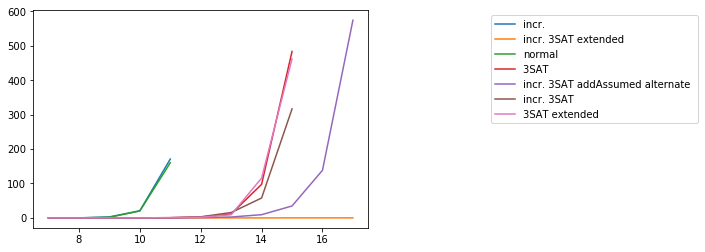

In [39]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == False)
    #& (df['conf.run'] == 2)
    & (
        (df['incphp.parameters.alternate'] == False)
      | (
           (df['incphp.parameters.addAssumed'] == True)
         & (df['conf.setup.incremental'] == True)
        )
      )
    & (df['conf.numPigeons'] > 6)
]

for confId, data in d.groupby("confId"):
    name = data.iloc[0]["name"]
    points = list()
    for numPigeons, data in data.groupby('conf.numPigeons'):
        if (len(data["time"].values) > 3):
            points.append((
                numPigeons,
                statistics.mean(data["time"].values)
            ))
    
    plt.plot(*zip(*points), label=name)

#plt.semilogy()
plt.legend(bbox_to_anchor=(2,1))
plt.show()